# Implementation of Lorentz Embeddings
An implemenation of Lorentz embeddings as described in "[Learning Continuous Hierarchies in the Lorentz Model of Hyperbolic Geometry](https://arxiv.org/pdf/1806.03417.pdf)" (Nickel and Kiela, 2018).  
*Notes by Xingyu Li, Feb 19, 2022*
  

# Basics
## Poincaré disk & ball model
The Poincaré disk is a model in which all points are in the interior of the unit disk in two dimensions, and the Poincaré ball, is its higher-dimensional cousin. Hyperbolic space is a beautiful and sometimes weird place. The “shortest paths”, called geodesics, are curved in hyperbolic space.  
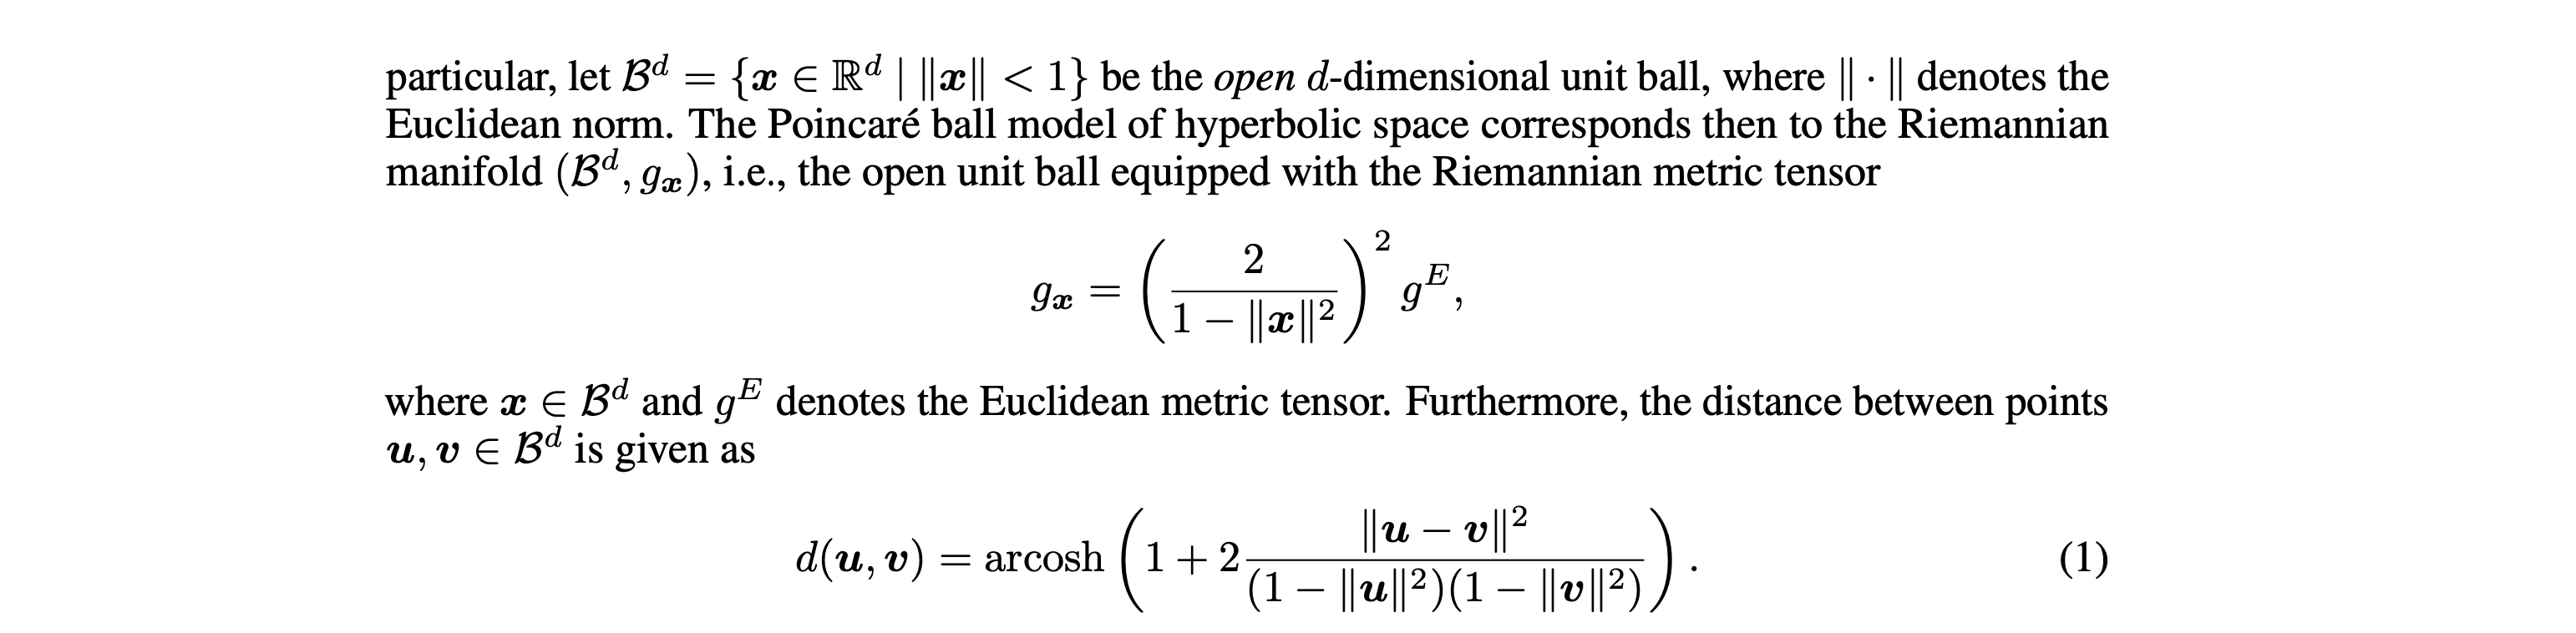
Ref:   [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/pdf/1705.08039.pdf)

  
The goal when embedding a graph G into a space V is to preserve the graph distance (the shortest path between a pair of vertices) in the space V.   
  
Consider three points: the origin O, and points x and y with $|x| = |y| = t$ for some t > 0. As shown on the right of Figure 1, as t → 1 (i.e., the points move towards the outside of the disk), in flat Euclidean space, the ratio $dE (x, y) / (dE (x, O) + dE (O, y))$ is constant with respect to t (blue curve). In contrast, the ratio $dH (x, y) / (dH (x, O) + dH (O, y))$ approaches 1, or, equivalently, the distance $dH (x, y)$ approaches $dH (x, O) + dH (O, y)$ (red and pink curves). That is, the shortest path between x and y is almost the same as the path through the origin. This is analogous to the property of trees in which the shortest path between two sibling nodes is the path through their parent. This tree-like nature of hyperbolic space is the key property exploited by embeddings. Moreover, this property holds for arbitrarily small angles between x and y.  
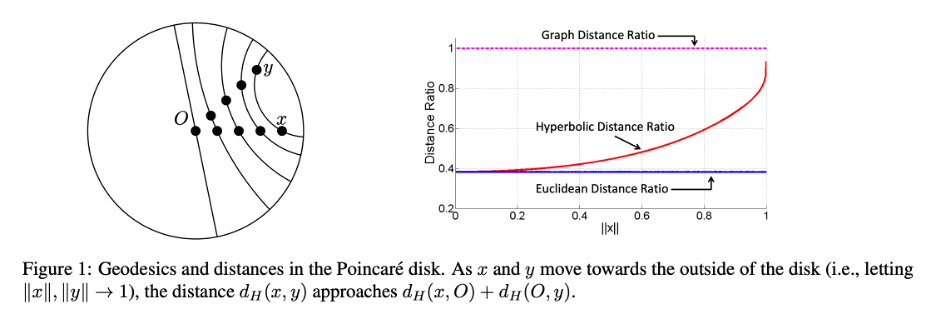  
  
The distance within the Poincaré ball changes smoothly with respect to the location of x and y. This locality property of the Poincaré distance is key for finding continuous embeddings of hierarchies. For instance, by placing the root node of a tree at O, it would have a relatively small distance to all other nodes as its Euclidean norm is zero. On the other hand, leaf nodes can be placed close to the boundary of the Poincaré ball as the distance grows very fast between points with a norm close to one.   
  
Furthermore, please note that Equation (1) is symmetric, and that the hierarchical organization of the space is solely determined by the distance of points to the origin. Due to this self-organizing property, Equation (1) is applicable in an unsupervised setting where the hierarchical order of objects is not specified in advance such as text and networks. Remarkably, Equation (1) allows us therefore to learn embeddings that simultaneously **capture the hierarchy of objects (through their norm) as well as their similarity (through their distance)**.  
  
Ref:  [Representation Tradeoffs for Hyperbolic Embeddings](https://arxiv.org/pdf/1804.03329.pdf)

## Lorentz hyperboloid model

Here, a new method is used to compute hyperbolic embeddings based on the Lorentz model of hyperbolic geometry.
The main advantage of this parameterization is that it allows us to perform Riemannian optimization very efficiently. An additional advantage is that its distance function (see Equation (5)) avoids numerical instabilities that arise from the fraction in the Poincaré distance.  
  

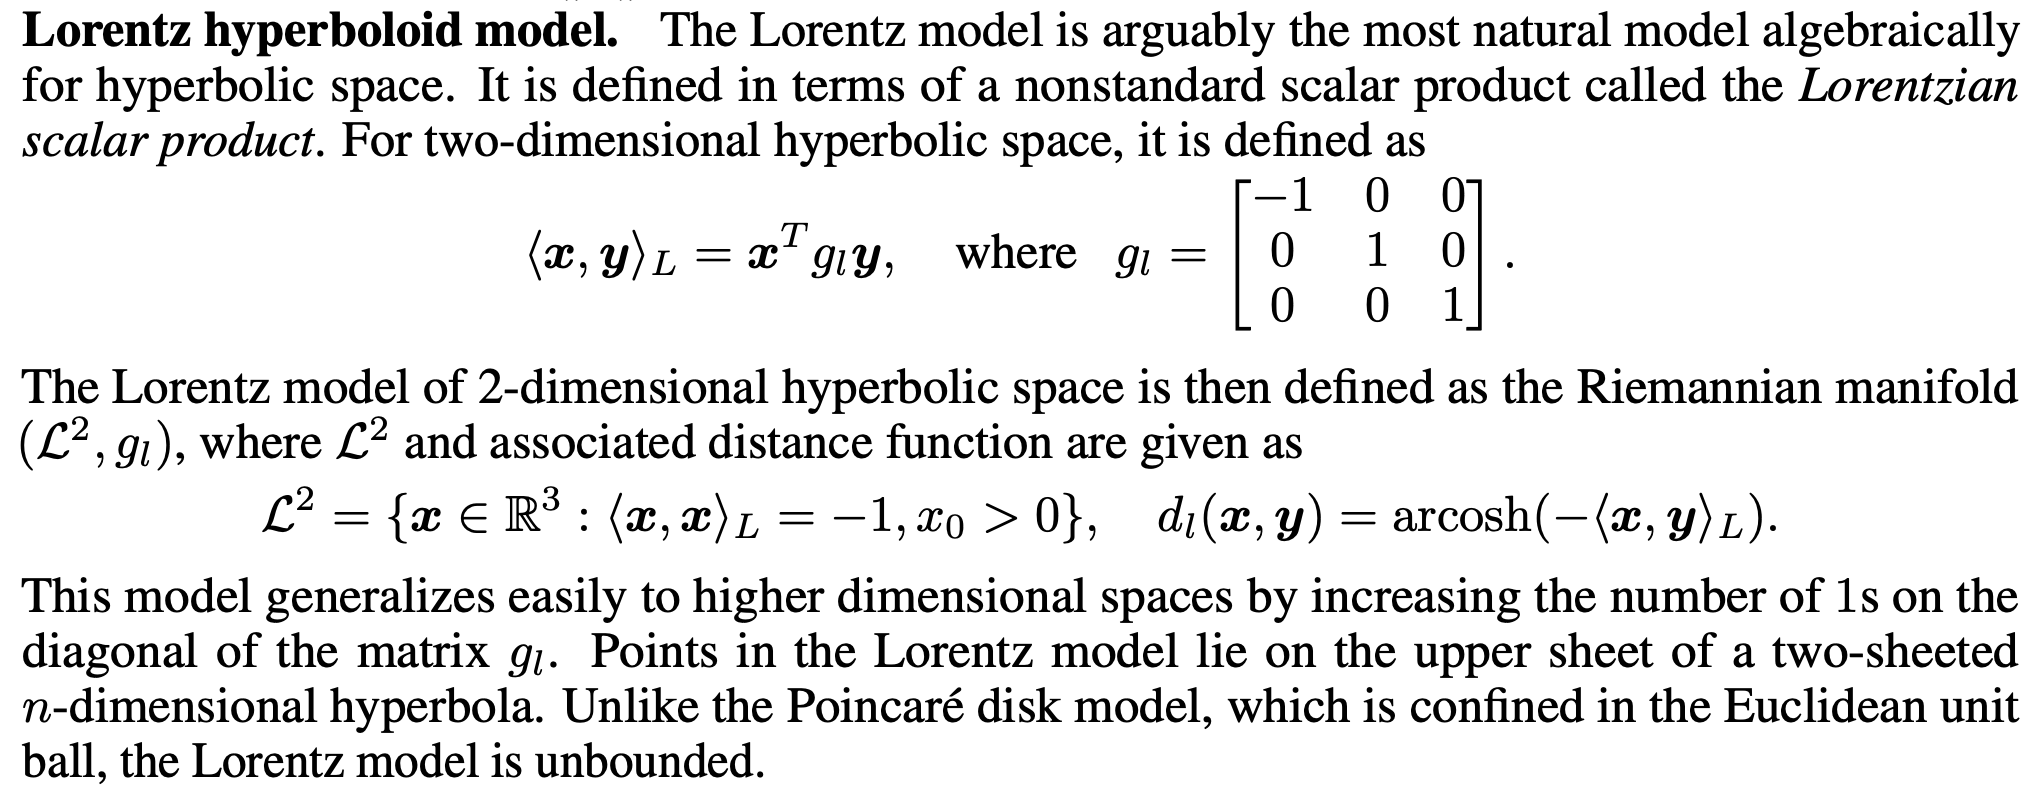 
Ref:  [Numerically Accurate Hyperbolic Embeddings Using Tiling-Based Models](https://proceedings.neurips.cc/paper/2019/file/82c2559140b95ccda9c6ca4a8b981f1e-Paper.pdf)

# Dataset Preparation

In [1]:
import numpy as np
from numpy.core.numeric import binary_repr
import pandas as pd
from tqdm import tqdm
import random
from scipy import sparse

## Simple trees for illustration?

In [15]:
def make_bin_tree():
    print("Datasets Available")
    print("-" * 20)
    # ################### Binary Tree
    depth = 5
    N = sum(2 ** i for i in range(depth))
    mat = np.zeros((N, N))
    for i in range(N):
        j = 2 * i + 1
        if j + 1 >= N:
            break
        mat[i, j] = 1
        mat[i, j + 1] = 1
    binary_tree = mat
    print("Binary Tree : binary_tree")
    return binary_tree
binary_tree = make_bin_tree()

def make_bin_tree_overlap():
    print("Datasets Available")
    print("-" * 20)
    # ################### Binary Tree
    depth = 5
    N = sum(2 ** i for i in range(depth))
    mat = np.zeros((N, N))
    for i in range(N):
        j = 2 * i + 1
        if j + 1 >= N:
            break
        mat[i, j] = random.randint(6,12)
        mat[i, j + 1] = random.randint(6,12)
        mat[j + 1,i]=random.randint(0,4)
        mat[j, i]=random.randint(0,4)
        if i<N-5:
            for samplei in range(2):
                h=random.randint(j+1,N-1)
                mat[i, h] = random.randint(6,12)
                mat[h, i] = random.randint(0, 4)
    binary_tree = mat
    print("binary_tree_overlap : binary_tree")
    return binary_tree
binary_tree_overlap = make_bin_tree_overlap()

# ################### Quad Tree
def make_quad_tree():
    depth = 4
    N = sum(4 ** i for i in range(depth))
    mat = np.zeros((N, N))
    for i in range(N):
        j = 4 * i + 1
        if j + 3 >= N:
            break
        mat[i, j] = 1
        mat[i, j + 1] = 1
        mat[i, j + 2] = 1
        mat[i, j + 3] = 1
    quad_tree = mat
    print("Quad Tree : quad_tree")
    print("-" * 20)
    return quad_tree
quad_tree = make_quad_tree()

Datasets Available
--------------------
Binary Tree : binary_tree
Datasets Available
--------------------
binary_tree_overlap : binary_tree
Quad Tree : quad_tree
--------------------


## Load PPMI file and use 1 to represent the (i,j) pair with count > 0.15.

In [20]:
def load_PPMI(csv_file,dic_file):
    print ("---PPMI-----")
    df = pd.read_csv(dic_file)
    token = list(df["index"])
    index_new = list(df["index_new"])
    dic_token_index = {str(t): int(i) for (t, i) in zip(token,index_new)}
    adj_matrix = np.zeros((len(token), len(token)), dtype=np.float32)
    df = pd.read_csv(csv_file)
    codes1 = list(df["i"])
    codes2 = list(df["j"])
    counts = list(df["count"])
    PPMI_threshold=0.15
    for code1,code2,count in zip(codes1,codes2,counts):
        value= 1 if count>PPMI_threshold else 0
        adj_matrix[dic_token_index[str(code2)], dic_token_index[str(code1)]] = value

    print("np.count_nonzero(adj_matrix) ratio: ", np.count_nonzero(adj_matrix)/(len(token)*len(token)))
    print("np.count_nonzero(adj_matrix): ", np.count_nonzero(adj_matrix))
    return adj_matrix
ppmi = load_PPMI("./data/PPMI_givenOut.csv","./data/BIDMC_conceptcode.csv")

---PPMI-----
np.count_nonzero(adj_matrix) ratio:  0.05497713763145862
np.count_nonzero(adj_matrix):  144282


# Lorentz Embeddings
A pytorch implementation of [Learning Continuous Hierarchies in the Lorentz Model of Hyperbolic Geometry](https://arxiv.org/pdf/1806.03417.pdf).
  
*We are concerned with the discovery of hierarchical relationships from large-scale unstructured similarity scores. For this purpose, we study different models of hyperbolic space and find that learning embeddings in the Lorentz model is substantially more efficient than in the Poincaré-ball model. We show that the proposed approach allows us to learn high-quality embeddings of large taxonomies which yield improvements over Poincaré embeddings, especially in low dimensions.*  

Reference: https://github.com/theSage21/lorentz-embeddings

In [3]:
import os
import sys
import torch
import random
import numpy as np
from torch import nn
from torch import optim
from tqdm import trange, tqdm
from collections import Counter
from datetime import datetime
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib

matplotlib.use("Agg")  # this needs to come before other matplotlib imports
import matplotlib.pyplot as plt

plt.style.use("ggplot")

 ## Define the calculations
 Lorentzian scalar product: $<x,y> = -x_0 y_0 + \sum\limits_{i=1}^n x_n y_n$   
   
 Distance:        $d_l(x,y) = arcosh(-<x,y>_L)$

In [21]:
def arcosh(x):
    return torch.log(x + torch.sqrt(x ** 2 - 1))


def lorentz_scalar_product(x, y):
    # BD, BD -> B
    m = x * y
    result = m[:, 1:].sum(dim=1) - m[:, 0]
    return result


def tangent_norm(x):
    # BD -> B
    return torch.sqrt(lorentz_scalar_product(x, x))


def exp_map(x, v):
    # BD, BD -> BD
    tn = tangent_norm(v).unsqueeze(dim=1)
    tn_expand = tn.repeat(1, x.size()[-1])
    result = torch.cosh(tn) * x + torch.sinh(tn) * (v / tn)
    result = torch.where(tn_expand > 0, result, x)  # only update if tangent norm is > 0
    return result


def set_dim0(x):
    x = torch.renorm(x, p=2, dim=0, maxnorm=1e2)  # otherwise leaves will explode
    # NOTE: the paper does not mention the square part of the equation but if
    # you try to derive it you get a square term in the equation
    dim0 = torch.sqrt(1 + (x[:, 1:] ** 2).sum(dim=1))
    x[:, 0] = dim0
    return x

## Riemannian Stochastic Gradient Descent (RSGD) optimizer  

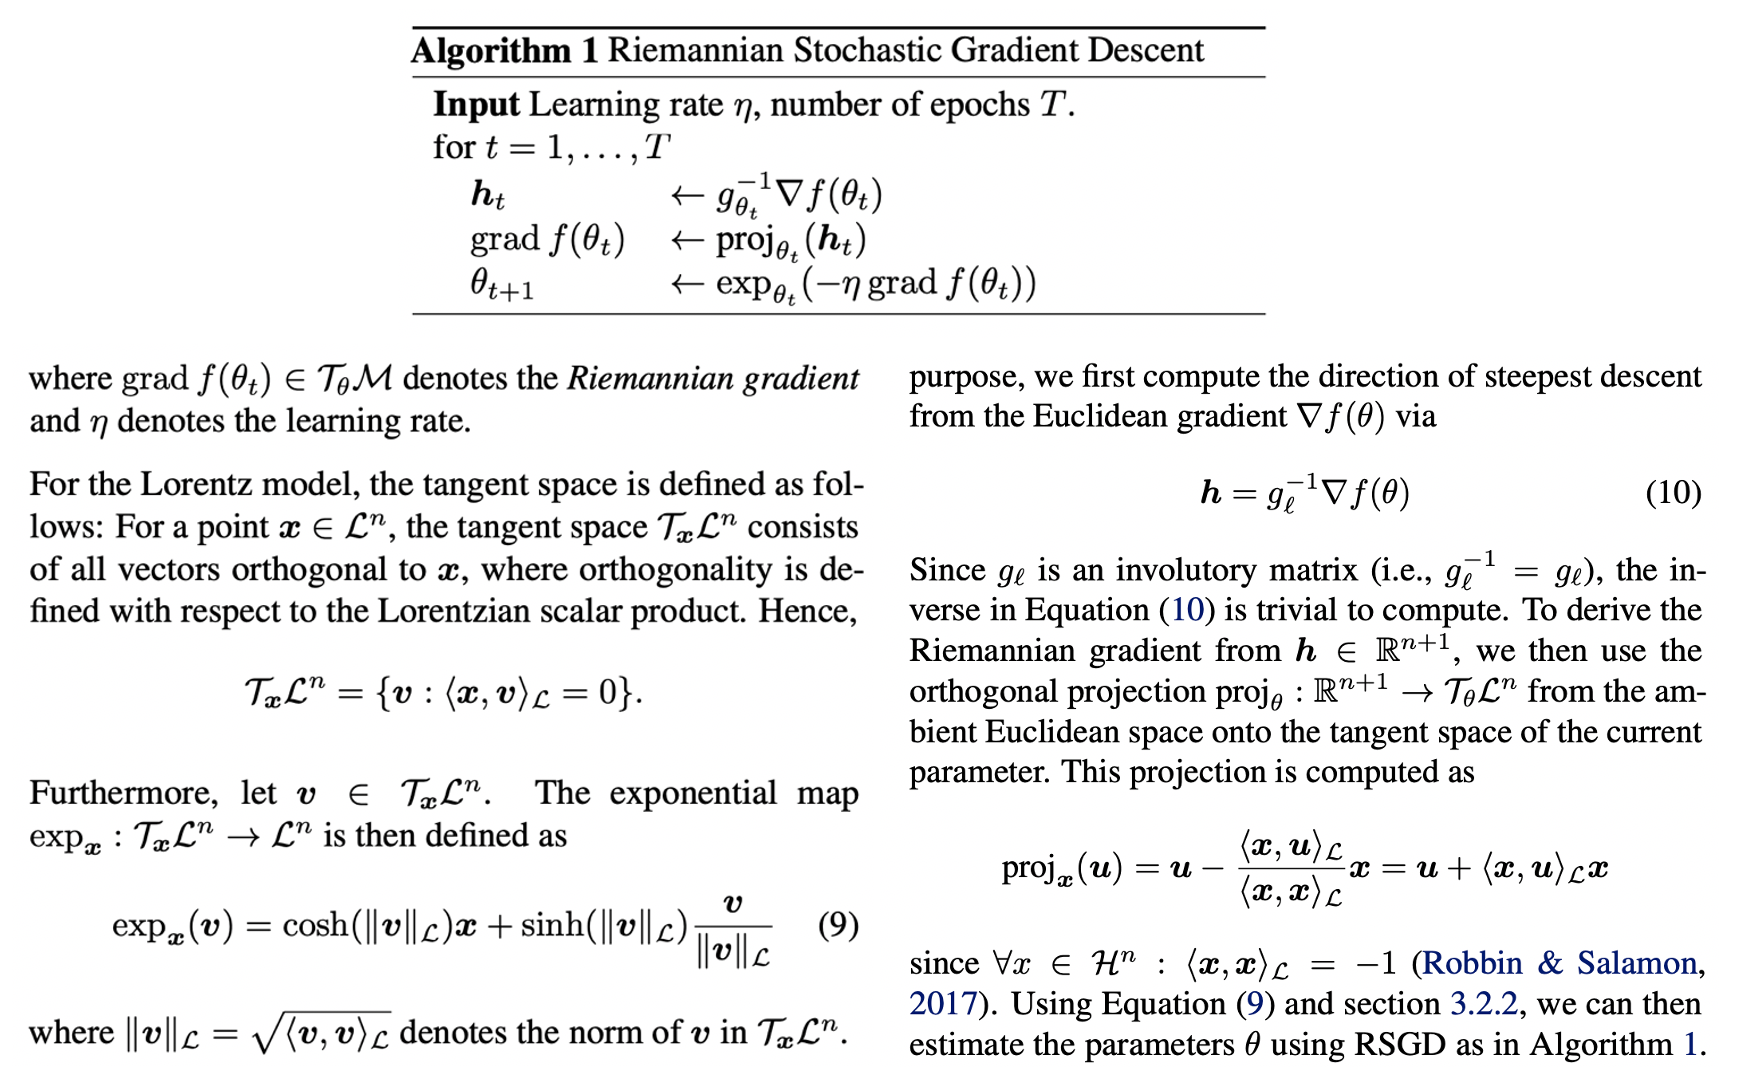


In [22]:
class RSGD(optim.Optimizer):
    def __init__(self, params, learning_rate=None):
        learning_rate = learning_rate if learning_rate is not None else 0.01
        defaults = {"learning_rate": learning_rate}
        super().__init__(params, defaults=defaults)

    def step(self):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                B, D = p.size()
                gl = torch.eye(D, device=p.device, dtype=p.dtype)
                gl[0, 0] = -1
                grad_norm = torch.norm(p.grad.data)
                grad_norm = torch.where(grad_norm > 1, grad_norm, torch.tensor(1.0))
                # only normalize if global grad_norm is more than 1
                h = (p.grad.data / grad_norm) @ gl
                proj = (
                    h
                    - (
                        lorentz_scalar_product(p, h) / lorentz_scalar_product(p, p)
                    ).unsqueeze(1)
                    * p
                )
                # print(p, lorentz_scalar_product(p, p))
                update = exp_map(p, -group["learning_rate"] * proj)
                is_nan_inf = torch.isnan(update) | torch.isinf(update)
                update = torch.where(is_nan_inf, p, update)
                update[0, :] = p[0, :]
                update = set_dim0(update)
                p.data.copy_(update)

##  Inferring Concept Hierarchies from Similarity
Loss function:  $Loss = \frac{e^-d(u_i,u_j)}{\sum\limits_{k\in N(i,j)}e^-d(u_i,u_k)}$  
 
 where $N(i,j)$ = {k : $X_{ik}$ < $X_{ij}$} ∪ { j }  denote the set of concepts that are less similar to $c_i$ then $c_j$ (including $c_j$).  
   
 
###  Lorentz $\Leftrightarrow$ Poincaré disk model
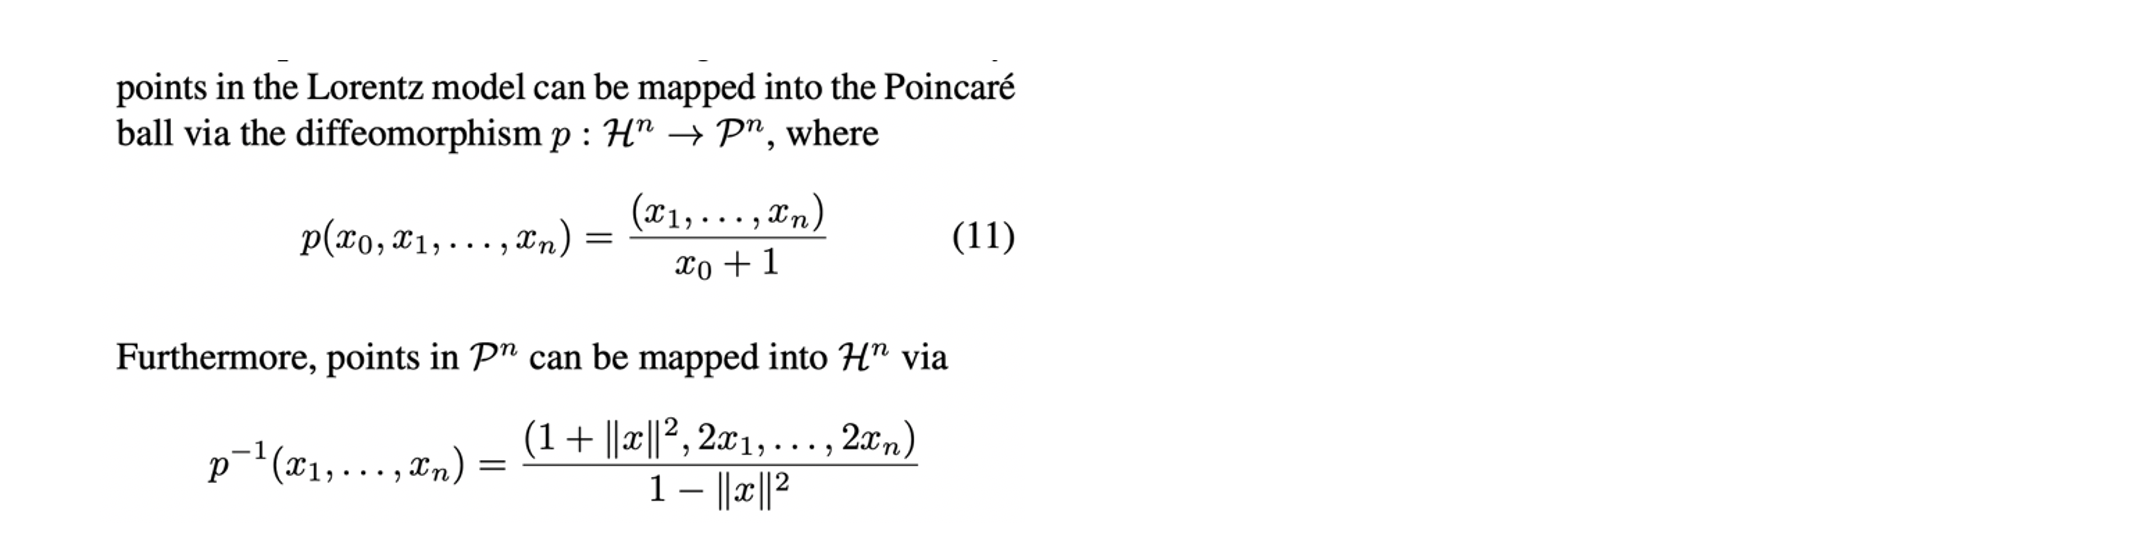
We will therefore learn the embeddings via Algorithm 1 in the Lorentz model and visualize the embeddings by mapping them into the Poincaré disk using the above equation. 

In [23]:
class Lorentz(nn.Module):
    """
    This will embed `n_items` in a `dim` dimensional lorentz space.
    """

    def __init__(self, n_items, dim, init_range=0.001):
        super().__init__()
        self.n_items = n_items
        self.dim = dim
        self.table = nn.Embedding(n_items + 1, dim, padding_idx=0)
        nn.init.uniform_(self.table.weight, -init_range, init_range)
        # equation 6
        with torch.no_grad():
            self.table.weight[0] = 5  # padding idx push it to corner
            set_dim0(self.table.weight)

    def forward(self, I, Ks):
        """
        Using the pairwise similarity matrix, generate the following inputs and
        provide to this function.

        Inputs:
            - I     :   - long tensor
                        - size (B,)
                        - This denotes the `i` used in all equations.
            - Ks    :   - long tensor
                        - size (B, N)
                        - This denotes at max `N` documents which come from the
                          nearest neighbor sample.
                        - The `j` document must be the first of the N indices.
                          This is used to calculate the losses
        Return:
            - size (B,)
            - Ranking loss calculated using
              document to the given `i` document.

        """
        n_ks = Ks.size()[1]
        ui = torch.stack([self.table(I)] * n_ks, dim=1)
        uks = self.table(Ks)
        # ---------- reshape for calculation
        B, N, D = ui.size()
        ui = ui.reshape(B * N, D)
        uks = uks.reshape(B * N, D)
        dists = -lorentz_scalar_product(ui, uks)
        dists = torch.where(dists <= 1, torch.ones_like(dists) + 1e-6, dists)
        # sometimes 2 embedding can come very close in R^D.
        # when calculating the lorenrz inner product,
        # -1 can become -0.99(no idea!), then arcosh will become nan
        dists = -arcosh(dists)
        # print(dists)
        # ---------- turn back to per-sample shape
        dists = dists.reshape(B, N)
        loss = -(dists[:, 0] - torch.log(torch.exp(dists).sum(dim=1) + 1e-6))
        return loss

    def lorentz_to_poincare(self):
        table = self.table.weight.data.numpy()
        return table[:, 1:] / (
            table[:, :1] + 1
        )  # diffeomorphism transform to poincare ball

    def get_lorentz_table(self):
        return self.table.weight.data.numpy()

    def _test_table(self):
        x = self.table.weight.data
        check = lorentz_scalar_product(x, x) + 1.0
        return check.numpy().sum()

### Generate concept hierarchy 

In [24]:
class Graph(Dataset):
    def __init__(self, pairwise_matrix, sample_size=10):
        self.pairwise_matrix = pairwise_matrix
        self.n_items = len(pairwise_matrix)
        self.sample_size = sample_size
        self.arange = np.arange(0, self.n_items)

    def __len__(self):
        return self.n_items

    def __getitem__(self, i):
        I = torch.Tensor([i + 1]).squeeze().long()
        has_child = (self.pairwise_matrix[i] > 0).sum()
        has_parent = (self.pairwise_matrix[:, i] > 0).sum()
        arange = np.random.permutation(self.arange)
        if has_parent:  # if no child go for parent
            for j in arange:
                if self.pairwise_matrix[j, i] > 0:  # assuming no disconneted nodes
                    min = self.pairwise_matrix[j, i]
                    break
        else:
            for j in arange:
                if self.pairwise_matrix[i, j] > 0:  # assuming no self loop
                    min = self.pairwise_matrix[i, j]
                    break
        # else:
        #     raise Exception(f"Node {i} has no parent and no child")

        arange = np.random.permutation(self.arange)
        if has_child:
            indices = [x for x in arange if i != x and self.pairwise_matrix[i, x] < min]
        else:
            indices = [x for x in arange if i != x and self.pairwise_matrix[x, i] < min]
        indices = indices[: self.sample_size]
        Ks = ([i + 1 for i in [j] + indices] + [0] * self.sample_size)[
            : self.sample_size
        ]
        # print(I, Ks)
        return I, torch.Tensor(Ks).long()

### Evaluate the reconstruction accuracy of the model
Return the proportion of successful reconstruction

In [25]:
def recon(table, pair_mat):
    "Reconstruction accuracy"
    count = 0
    table = torch.tensor(table[1:])
    for i in range(1, len(pair_mat)):  # 0 padding, 1 root, we leave those two
        x = table[i].repeat(len(table)).reshape([len(table), len(table[i])])  # N, D
        mask = torch.tensor([0.0] * len(table))
        mask[i] = 1
        mask = mask * -10000.0
        dists = lorentz_scalar_product(x, table) + mask
        dists = (
            dists.numpy()
        )  # arccosh is monotonically increasing, so no need of that here
        # and no -dist also, as acosh in m i, -acosh(-l(x,y)) is nothing but l(x,y)
        # print(dists)
        predicted_parent = np.argmax(dists)
        actual_parent = np.argmax(pair_mat[:, i])
        # print(predicted_parent, actual_parent, i, end="\n\n")
        count += actual_parent == predicted_parent
    count = count / (len(pair_mat) - 1) * 100
    return count

### ?

In [26]:
_moon_count = 0


def _moon(loss, phases="🌕🌖🌗🌘🌑🌒🌓🌔"):
    global _moon_count
    _moon_count += 1
    p = phases[_moon_count % 8]
    return f"{p} Loss: {float(loss)}"

### Set the parameters

In [35]:
datasets = pd.read_csv("./data/PPMI_givenOut.csv")  # File:pairwise_matrix
n_items = 10000 # How many items to embed?
sample_size = 5  # How many samples in the N matrix
batch_size = 32  # How many samples in the batch
burn_c = 10      # Divide learning rate by this for the burn epochs
burn_epochs = 100 # How many epochs to run the burn phase for?
plot_size = 3 # Size of the plot
plot_graph = False # Plot the Graph associated with the embeddings
overwrite_plots = False # Overwrite the plots?
ckpt = None # Which checkpoint to use?
shuffle = True # Shuffle within batch while learning?
epochs = 1_000_000 # How many epochs to optimize for?
poincare_dim = 2 # Poincare projection time. Lorentz will be + 1
learning_rate = 0.1 # RSGD learning rate
log_step = 1 # Log at what multiple of epochs?
logdir = "runs" # What folder to put logs in
save_step = 3000 # Save at what multiple of epochs?
savedir = "ckpt" # What folder to put checkpoints in
loader_workers = 4 # How many workers to generate tensors

In [36]:
datasets

,count,i,j
0,0.000168,1,34
1,0.000201,1,57
2,0.000105,1,61
3,0.041862,1,667
4,0.064456,1,668
...,...,...,...
174139,0.017162,1620,1578
174140,0.015593,1620,1588
174141,0.166389,1620,1597
174142,0.070774,1620,1599


### Embed items in Lorentz space

In [39]:
if not os.path.exists(logdir):
    os.mkdir(logdir)
if not os.path.exists(savedir):
    os.mkdir(savedir)
# ----------------------------------- get the correct matrix
n_items = len(pairwise) if n_items is None else n_items
pairwise = datasets[0:n_items]
n_items = len(pairwise)
print(f"{n_items} being embedded")

# ---------------------------------- Generate the proper objects
net = Lorentz(
    n_items, poincare_dim + 1
)  # as the paper follows R^(n+1) for this space

10000 being embedded


### Visualization

In [ ]:
df = pd.read_csv("./data/covid_codes_selected_added.csv")
names = list(df["names"])
index_new = list(df["index_new"])
dic_index_name = {int(i): str(name) for (i, name) in zip(index_new, names)}

paths = paths[:]
target_codes=["death","icu","hospitalized","covidpos","HCQ","ECMO","ARDS","COVIDVIRAL","CTChest"]
target_codes_index=[4,6,5,66,70,71,74,75,69,24,67,65,77,78,72,14,21]
for path in tqdm(paths, desc="Plotting"):
    save_path = f"{path}.svg"
    if os.path.exists(save_path) and not overwrite_plots:
        continue
    net.load_state_dict(torch.load(path))
    table = net.lorentz_to_poincare()
    # skip padding. plot x y
    plt.figure(figsize=(12, 12))
    if plot_graph:
        for edge in edges:
            # plt.plot(
            #     table[edge, 0],
            #     table[edge, 1],
            #     color="black",
            #     marker="o",
            #     alpha=0.4,
            # )

            plt.plot(
                table[edge, 0],
                table[edge, 1],
                color="black",
                alpha=0.2,
                linewidth=0.3
            )
        #print("-----ploting edges")
        plt.scatter(0, 0,marker="*",color="red",linewidth=4,alpha=0.5)
        for rowi in range(len(table) - 1):
            s = str(rowi)
            color = "black"
            fontsize_value = 7
            if rowi in dic_index_name:
                s=dic_index_name[rowi]
            if int(rowi) in target_codes_index:
                color = "red"
                fontsize_value = 9
            plt.text(table[1 + rowi:rowi + 1 + 1, 0],
                     table[1 + rowi:rowi + 1 + 1, 1], s, fontsize=fontsize_value,color=color)
            plt.scatter(table[1 + rowi:rowi + 1 + 1, 0], table[1 + rowi:rowi + 1 + 1, 1])
    else:
        plt.scatter(0, 0, marker="*", color="red", linewidth=4,alpha=0.5)
        print ("-----ploting points")
        print ("len(table): ",len(table))
        #plt.scatter(table[1:, 0], table[1:, 1])
        for rowi in range(len(table)-1):
            s = str(rowi)
            color="black"
            fontsize_value=7
            if rowi in dic_index_name:
                s = dic_index_name[rowi]
            if int(rowi) in target_codes_index:
                color = "red"
                fontsize_value = 9
            plt.text(table[1+rowi:rowi+1+1, 0], table[1+rowi:rowi+1+1, 1], s, fontsize=fontsize_value,color=color)
            plt.scatter(table[1+rowi:rowi+1+1, 0], table[1+rowi:rowi+1+1, 1])
    plt.title(path)
    plt.gca().set_xlim(-1, 1)
    plt.gca().set_ylim(-1, 1)
    plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
    plt.savefig(save_path)
    plt.savefig(save_path+".png", dpi=150)
    plt.close()
sys.exit(0)

###  Riemannian Optimization in the Lorentz Model

In [40]:
dataloader = DataLoader(
    Graph(pairwise, sample_size),
    shuffle=shuffle,
    batch_size=batch_size,
    num_workers=loader_workers,
)
rsgd = RSGD(net.parameters(), learning_rate=learning_rate)

name = f"{datasets}  {datetime.utcnow()}"
writer = SummaryWriter(f"{logdir}/{name}")

with tqdm(ncols=80, mininterval=0.2) as epoch_bar:
    for epoch in range(epochs):
        rsgd.learning_rate = (
            learning_rate / burn_c
            if epoch < burn_epochs
            else learning_rate
        )
        for I, Ks in dataloader:
            rsgd.zero_grad()
            loss = net(I, Ks).mean()
            loss.backward()
            rsgd.step()
        writer.add_scalar("loss", loss, epoch)
        writer.add_scalar(
            "recon_preform", recon(net.get_lorentz_table(), pairwise), epoch
        )
        writer.add_scalar("table_test", net._test_table(), epoch)
        if epoch % args.save_step == 0:
            torch.save(net.state_dict(), f"{savedir}/{epoch} {name}.ckpt")
        epoch_bar.set_description(
            f"🔥 Burn phase loss: {float(loss)}"
            if epoch < burn_epochs
            else _moon(loss)
        )
        epoch_bar.update(1)

OSError: [Errno 63] File name too long: 'runs/           count     i     j\n0       0.000168     1    34\n1       0.000201     1    57\n2       0.000105     1    61\n3       0.041862     1   667\n4       0.064456     1   668\n...          ...   ...   ...\n174139  0.017162  1620  1578\n174140  0.015593  1620  1588\n174141  0.166389  1620  1597\n174142  0.070774  1620  1599\n174143  0.068901  1620  1605\n\n[174144 rows x 3 columns]  2022-02-20 04:19:47.558020'